In [1]:
import numpy as np
from loss import *
from utils import *
import skopt
from matplotlib import pyplot as plt
from skopt import gp_minimize
import pandas as pd

import warnings
warnings.filterwarnings(action='once')

from skopt.learning import (GaussianProcessRegressor, RandomForestRegressor,
                            GradientBoostingQuantileRegressor)

from multiprocessing import Pool, Process
from skopt import Optimizer

In [2]:
%%time
results = []
def run_optimization(args, points=200, acq='EI', IS=True):
    func = args[0]
    random_state = args[1]
    
    opt = Optimizer(dimensions=[(-20.0, 20.0), (-20.0, 20.0)], base_estimator=GaussianProcessRegressor(
                alpha=1e-3, noise='gaussian'), acq_func='EI', random_state=random_state)
    for i in range(points):
        x = opt.ask()
        if IS is True:
            y = func(x, sample_share=0.3, update_weights=True)
        else:
            y = func(x, sample_share=0.3, update_weights=False)
            
        opt.tell(x, y)
        if np.linalg.norm(x) < 0.1:
            return opt
    return opt

p = Pool(4)

for i in range(10):
    args = [(LossPois(seed=1), i * 10 + x) for x in range(4)]
    for arg in args:
        arg[0](np.ones(2), sample_share=1, update_weights=True)


    res = p.map(run_optimization, args)
    print(i)
    results += res

p.close()

0
1
2
3
4
5
6
7
8
9
CPU times: user 2.94 s, sys: 29.4 s, total: 32.4 s
Wall time: 19min 58s


In [3]:
obj = LossPois(seed=1)

In [4]:
obj_values = []
for opt in results:
    values = []
    for x in opt.Xi:
        values.append(obj(np.array(x)))
    obj_values.append(values)

In [10]:
mean_vector = []
for i in range(0, len(obj_values[0])):
    def sup(x):
        if len(x) > i:
            return x[i]
        else:
            return np.nan
    res = np.array(list(map(sup, obj_values)))
    mean_vector.append(np.mean(res[np.logical_not(np.isnan(res))]))

In [14]:
%%time
results_not_is = []
def run_optimization(args, points=200, acq='EI', IS=False):
    func = args[0]
    random_state = args[1]
    
    opt = Optimizer(dimensions=[(-20.0, 20.0), (-20.0, 20.0)], base_estimator=GaussianProcessRegressor(
                alpha=1e-3, noise='gaussian'), acq_func='EI', random_state=random_state)
    for i in range(points):
        x = opt.ask()
        if IS is True:
            y = func(x, sample_share=0.3, update_weights=True)
        else:
            y = func(x, sample_share=0.3, update_weights=False)
            
        opt.tell(x, y)
        if np.linalg.norm(x) < 0.1:
            return opt
    return opt

p = Pool(4)

for i in range(10):
    args = [(LossPois(seed=1), i * 10 + x) for x in range(4)]
    for arg in args:
        arg[0](np.ones(2), sample_share=1, update_weights=True)


    res = p.map(run_optimization, args)
    print(i)
    results_not_is += res

p.close()

0
1
2
3
4
5
6
7
8
9
CPU times: user 3.32 s, sys: 37.2 s, total: 40.5 s
Wall time: 20min 59s


In [17]:
obj_values_not_is = []
for opt in results_not_is:
    values = []
    for x in opt.Xi:
        values.append(obj(np.array(x)))
    obj_values_not_is.append(values)

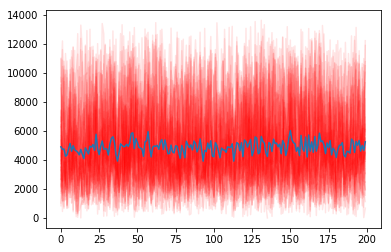

In [11]:
for row in obj_values:
    plt.plot(row, c='r',alpha=0.1)
plt.plot(mean_vector)
plt.legend()
plt.show()

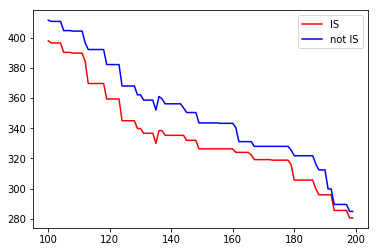

In [19]:
cum_minima = pd.DataFrame(obj_values).cummin(axis=1).mean(axis=0)
cum_minima_not_is = pd.DataFrame(obj_values_not_is).cummin(axis=1).mean(axis=0)

plt.plot(cum_minima[100:], c='r', label='IS')
plt.plot(cum_minima_not_is[100:], c='b', label='not IS')

plt.legend()
plt.show()